In [1]:
"""
@author: Zongyi Li
This file is the Fourier Neural Operator for 1D problem such as the (time-independent) Burgers equation discussed in Section 5.1 in the [paper](https://arxiv.org/pdf/2010.08895.pdf).
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)


################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 5 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        #x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        #x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(-6, 0, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

In [2]:
################################################################
#  configurations
################################################################
ntrain = 2900
ntest = 100

#sub = 2**3 #subsampling rate
#h = 2**13 // sub #total grid size divided by the subsampling rate
s = 207

batch_size = 20
learning_rate = 0.001

epochs = 500
step_size = 50
gamma = 0.5

modes = 32
width = 85

In [323]:
################################################################
# read data
################################################################
x_data = torch.tensor(np.load('data/input53.npy', allow_pickle=True))
y_data = torch.tensor(np.load('data/u_results53.npy', allow_pickle=True))


x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]
x_test = x_data[-ntest:,:]
y_test = y_data[-ntest:,:]

x_train = x_train.reshape(ntrain,s,1)
x_test = x_test.reshape(ntest,s,1)

In [324]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [325]:
# model
model = FNO1d(modes, width).cuda()
print(count_params(model))

1890232


In [326]:
################################################################
# training and evaluation
################################################################
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)

        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # use the l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_mse, train_l2, test_l2)

# torch.save(model, 'model/ns_fourier_burgers')
pred = torch.zeros(y_test.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x.cuda(), y.cuda()

        out = model(x).view(-1)
        pred[index] = out

        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        print(index, test_l2)
        index = index + 1

#scipy.io.savemat('pred/burger_test.mat', mdict={'pred': pred.cpu().numpy()})

0 1.5703005166724324 0.018588540185210778 0.11260771833617111 0.04102827072143555
1 1.5426119212061167 0.00047927049534588026 0.02821306394091968 0.020722353160381318
2 1.4935257053002715 0.0003759274987307185 0.02481213209444079 0.01760694891214371
3 1.6274528382346034 0.0001671646875208886 0.017398046018748448 0.025229267477989196
4 1.4997469810768962 0.0001661696685287411 0.017849983912089775 0.024186618030071258
5 1.520691804587841 0.00011438864588352114 0.014881750047206878 0.014306279122829437
6 1.5198997696861625 6.928597894298506e-05 0.01133854950810301 0.02039456844329834
7 1.4951485823839903 8.389154740896252e-05 0.012431541105796551 0.010885674059391021
8 1.5538757238537073 5.250556397217663e-05 0.009916797277742419 0.008770878612995147
9 1.5974573688581586 7.580008735611296e-05 0.012098997111978201 0.010875176340341568
10 1.6451824055984616 5.4326272602965816e-05 0.010028996138737119 0.008816519975662232
11 1.6099159605801105 4.5788289540284715e-05 0.00928337318116221 0.010

95 1.5015623373910785 4.906048320663103e-06 0.003058874786927782 0.004528247117996216
96 1.5062972018495202 3.839820867753964e-06 0.0027238691951437244 0.002383696809411049
97 1.4855010407045484 4.111956066261538e-06 0.002812071943591381 0.001903584785759449
98 1.4904027627781034 2.121903546124266e-06 0.0020025501888373803 0.0018043438717722893
99 1.4873069617897272 4.4990015896536504e-06 0.0029356204005407875 0.0030182271450757982
100 1.4819283448159695 1.0493053648901722e-06 0.0013878887522451836 0.0015153619088232517
101 1.4869935121387243 9.332210758092798e-07 0.0013555814386827165 0.0013867785595357417
102 1.4691528603434563 8.871848477015035e-07 0.0013150839282777803 0.002173110879957676
103 1.4766735257580876 9.424824117465097e-07 0.0013540470757489574 0.001927599050104618
104 1.4705243036150932 9.744446466466515e-07 0.001358755469514892 0.0015971836633980273
105 1.502173325046897 1.134786156328495e-06 0.0014847216883610034 0.0013102421909570695
106 1.5051102070137858 8.31903825

188 1.4844383681192994 3.014461227700128e-07 0.0007611955064830595 0.0006869650818407536
189 1.4746071556583047 2.6005949928080084e-07 0.0006994201003670178 0.0007305157836526632
190 1.4723653579130769 2.0419143826812019e-07 0.000625079603994201 0.0006452766805887223
191 1.4939401810988784 2.0029700415346363e-07 0.0006123765349259665 0.0005389958620071411
192 1.4688884392380714 3.571845583688424e-07 0.0008265802180715676 0.0005091587360948324
193 1.463959745131433 2.942342354313512e-07 0.0007516419116793008 0.000663956357166171
194 1.5033046025782824 2.841230347638069e-07 0.0007485398915114587 0.0007136684097349644
195 1.4957901360467076 2.091294701182082e-07 0.0006385631253942848 0.0009537064470350742
196 1.4464498776942492 3.279844499349471e-07 0.0007862988459588639 0.0005235175881534815
197 1.5088063245639205 2.9217102038579656e-07 0.0007421197250870795 0.0007387559674680233
198 1.494794956408441 3.1475915126724555e-07 0.0007825658706434328 0.0005813439004123211
199 1.48881409224122

280 1.4669940322637558 4.8926577008991254e-08 0.00029963243383400397 0.000346014266833663
281 1.4854444824159145 4.79246561209736e-08 0.0002970328779313071 0.00033114361576735973
282 1.4782105423510075 5.3759774269028166e-08 0.0003162661515947046 0.0002840694272890687
283 1.476946098729968 5.096716694050303e-08 0.0003075483222973758 0.0003635267121717334
284 1.5511584402993321 5.343313224831694e-08 0.0003157660456631204 0.00034824522212147715
285 1.4985895827412605 5.634368662054479e-08 0.00032407613776238827 0.00037314207293093204
286 1.525312166661024 5.51626241635153e-08 0.000321268191850134 0.0003169670794159174
287 1.4811192257329822 5.105682120152966e-08 0.0003071971393415126 0.00034726448822766545
288 1.4829993844032288 5.5568217356263346e-08 0.00032215780578553676 0.0002852092031389475
289 1.4859598223119974 5.0348691187133256e-08 0.0003051035844817244 0.0003561038384214044
290 1.4938733568415046 4.999986649999034e-08 0.0003037460914267034 0.00031624883413314817
291 1.465524541

372 1.5016427859663963 3.186562247786493e-08 0.00023513473249201118 0.0002543473709374666
373 1.4564574221149087 3.246986753032584e-08 0.0002373253420830287 0.00027347664814442396
374 1.4703663671389222 3.2271936479466195e-08 0.00023723883578425338 0.0002566596958786249
375 1.4979051798582077 3.193476624903332e-08 0.0002350876651351051 0.0002557966206222773
376 1.491437948308885 3.3917987805360666e-08 0.00024344403826599491 0.0002790568210184574
377 1.4830759186297655 3.173533649203364e-08 0.0002348341400221247 0.0002546446304768324
378 1.4830987844616175 3.165996020750926e-08 0.0002344504967813605 0.000266142669133842
379 1.448055217973888 3.204089783684265e-08 0.00023651056144193843 0.0002555148396641016
380 1.4798671146854758 3.149577639613528e-08 0.00023404427234019186 0.00024750393349677325
381 1.4856374999508262 3.100733781613191e-08 0.00023150029487843657 0.00025828666519373656
382 1.4829143630340695 3.250060963956724e-08 0.00023798437427793599 0.00025331904646009207
383 1.49856

463 1.52447406668216 2.763918960368983e-08 0.00021479644387125454 0.00023724628612399102
464 1.5098509695380926 2.755929091066413e-08 0.0002147636162759415 0.00023750912165269256
465 1.4847937747836113 2.7479394741290215e-08 0.00021378265557296831 0.0002379186125472188
466 1.4503131350502372 2.745751045992996e-08 0.00021382477913244532 0.00023883393500000237
467 1.477432617917657 2.787279916144167e-08 0.00021553869583997232 0.000237623555585742
468 1.46397843118757 2.7682235213678174e-08 0.00021511357743293048 0.00024093226995319127
469 1.4769423948600888 2.7413751765177966e-08 0.00021417308839616076 0.00023788523860275744
470 1.5031586410477757 2.7953769426417316e-08 0.00021661543905542328 0.00024224669206887483
471 1.5126839941367507 2.737841063132715e-08 0.00021353719282317266 0.0002456761384382844
472 1.5122561734169722 2.7524398061900526e-08 0.0002143784495199035 0.00023855790263041854
473 1.5930865397676826 2.7301843887577322e-08 0.00021292130679598657 0.00024245911510661244
474 

In [ ]:
pred.shape

In [ ]:
y_test.shape

In [3]:
model1 = torch.load('KFR_FNO_dtskip_type')

# Iteration 

In [12]:
time = []
#trajectory = y_test[-1,:].cpu().numpy()
start_timer = default_timer()
w = model1(U53[2000,:].float().reshape(1,s,1).cuda())
time.append(w.cpu().detach().numpy())
for i in range(0,6):
    with torch.no_grad():
        w = model1(w)
    time.append(w.cpu().detach().numpy())
end_timer = default_timer()
print("Time for Evaluation: ", end_timer - start_timer)

    
timenp = np.array(time)

timenp = timenp[:,-1,:,-1]

Time for Evaluation:  0.022303415462374687


In [568]:
aa1 = np.append(x_test[0::20,-1], timenp[:,-1])

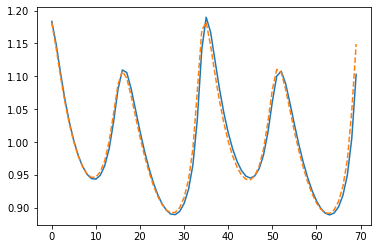

In [638]:
plt.plot(x_train[0::20,-1]) #4.85

plt.plot(timenp[:,-1], '--')

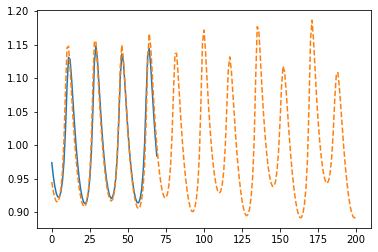

In [589]:
plt.plot(x_train[0::20,-1]) #4.72

plt.plot(timenp[:,-1], '--')

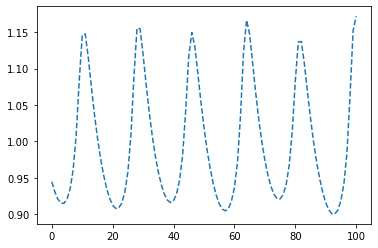

In [586]:
plt.plot(timenp[:,-1], '--')

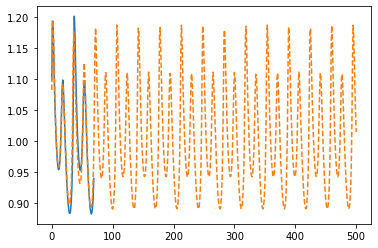

In [629]:
plt.plot(x_train[0::20,-1]) #4.9

plt.plot(timenp[:,-1], '--')

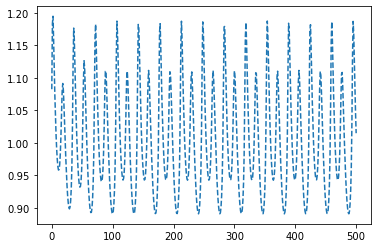

In [628]:
plt.plot(timenp[:,-1], '--')

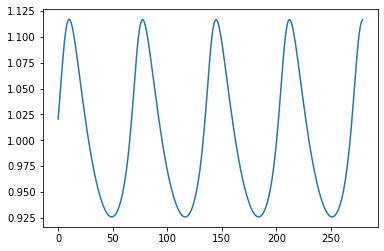

In [743]:
plt.plot(x_train[0::5,-1]) #4.5

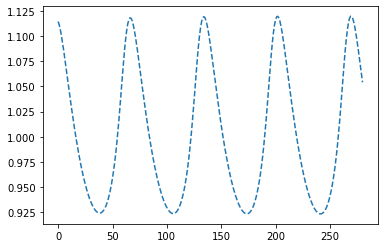

In [741]:
plt.plot(timenp[:,-1], '--')

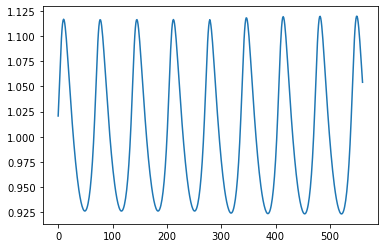

In [745]:
plt.plot(np.append(x_train[0::5,-1],timenp[:,-1])) #4.5

(300.0, 1000.0)

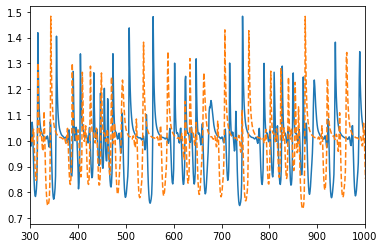

In [285]:
plt.plot(np.append(U55[1500::50,-1],timenp[:,-1]))

plt.plot(timenp[:,-1],'--')

plt.xlim([300,1000])

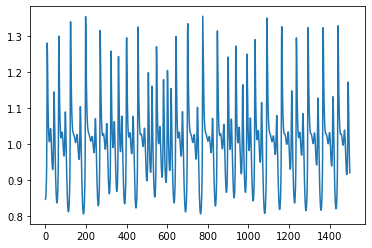

In [342]:
plt.plot(U53[2000::20,-1])

#plt.plot(timenp[:,-1],'--')

#plt.xlim([0,1000])

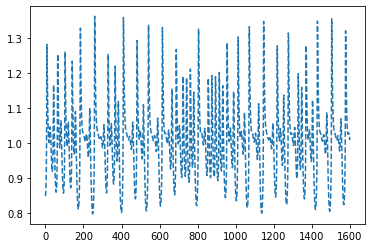

In [343]:
plt.plot(timenp[:,-1],'--')

# Comparison

In [4]:
U53 = torch.tensor(np.load('data/u_original53.npy', allow_pickle=True))

In [257]:
U55 = torch.tensor(np.load('data/u_original55.npy', allow_pickle=True))

In [346]:
U_th = torch.tensor(np.load('data/u_original485.npy', allow_pickle=True))

In [705]:
U_th = U_th[(7380-1501)::20,-1]

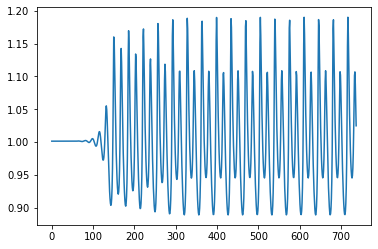

In [347]:
plt.plot(U_th[::20,-1])

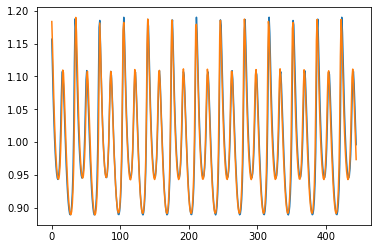

In [704]:
plt.plot(U_th[(7380-1501)::20,-1]) #WOW!

plt.plot(U_exp)

In [696]:
U_exp = np.append(x_train[0::20,-1],timenp[:,-1])

In [697]:
U_exp.shape

(445,)

In [706]:
error485 = U_th - U_exp

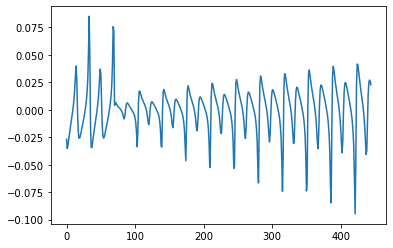

In [708]:
plt.plot(error485)

In [746]:
U45 = torch.tensor(np.load('data/u_original45.npy', allow_pickle=True))